In [ ]:
!pip install tensorflow
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 5.8 MB 37.0 MB/s 
     |████████████████████████████████| 1.6 MB 43.7 MB/s 
     |████████████████████████████████| 438 kB 53.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [1]:
!mkdir images

In [2]:

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import pathlib
import tensorflow_datasets as tfds

from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


Mounted at /content/drive
2.8.2


In [ ]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.image_dataset_from_directory.load_data()
print(train_images.shape)
#print(test_images.shape)

In [3]:
import os
import cv2 
import random
from PIL import Image
n=256
all_img_list = os.listdir("/content/drive/MyDrive/P images/train/P train")
dataset_list = random.sample(all_img_list, n) #Get n random images from the directory
#Read images, resize and capture into a numpy array
dataset = []
for img in dataset_list:
    temp_img = cv2.imread("/content/drive/MyDrive/P images/train/P train/" + img)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB) #opencv reads images as BGR so let us convert back to RGB
    temp_img = Image.fromarray(temp_img)
    #temp_img = temp_img.convert('L')
    temp_img = temp_img.resize((128,128))
    dataset.append(np.array(temp_img))   

train_images = np.array(dataset) #Convert the list to numpy array

In [4]:
train_images.shape

(256, 128, 128, 3)

In [5]:
TRAIN_BUF=256
BATCH_SIZE=256
#TEST_BUF=10000
DIMS = (128,128,3)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
#N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


# normalizing and reshaping dataset
# (m,28,28) to (m,28,28,1)
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3).astype("float32") / 255.0

#test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

#test_dataset = (
#    tf.data.Dataset.from_tensor_slices(test_images)
#    .shuffle(TEST_BUF)
#    .batch(BATCH_SIZE)
#)

In [6]:
class WGAN(tf.keras.Model):
    """
    
    Extends tf.keras.Model

    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)   
    
    def compute_loss_critic(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])  ## random noise with shape = (batch_size, 1, 1, n_Z)

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x_gen)  #
            - tf.reduce_mean(logits_x)
            + d_regularizer * self.gradient_penalty_weight
        )
        
        return disc_loss
      
    def compute_loss_generator(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])  #
        x_gen = self.generate(z_samp)
        logits_x_gen = self.discriminate(x_gen)
        # losses of fake with label "1"
        gen_loss = -tf.reduce_mean(logits_x_gen)
        
        return gen_loss

    def compute_gradients_critic(self, x):
      
        with tf.GradientTape() as disc_tape:
            disc_loss = self.compute_loss_critic(x)

        # compute gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return disc_gradients
      
    def compute_gradients_generator(self, x):
        
        with tf.GradientTape() as gen_tape:
            gen_loss = self.compute_loss_generator(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        return gen_gradients
      
      

    def apply_gradients_critic(self, disc_gradients):
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
        
    def apply_gradients_generator(self, gen_gradients):
        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
      


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

      

    @tf.function
    def train(self, train_x):
      
      for _ in range(self.n_critic):
        disc_gradients = self.compute_gradients_critic(train_x)
        self.apply_gradients_critic(disc_gradients)
      
      gen_gradients = self.compute_gradients_generator(train_x)
      self.apply_gradients_generator(gen_gradients)
              
        
    def sample_images(self, epoch):

        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.n_Z))
        
        gen_imgs = self.generate(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].matshow(
                    gen_imgs[cnt, :,:,0], cmap=plt.cm.Greys, vmin=0, vmax=1
                )
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/img_%d.png" % epoch)
        plt.close()

In [22]:
N_Z = 64

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
]

In [7]:
####different model
latent_dim=100
n_nodes = 128 * 8 * 8
in_shape=(128,128,3)
generator = [
              tf.keras.layers.Dense(units=n_nodes),
              tf.keras.layers.LeakyReLU(alpha=0.2),
              tf.keras.layers.Reshape((8, 8, 128)),
              # upsample to 16x16
              tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
              tf.keras.layers.LeakyReLU(alpha=0.2),
              # upsample to 32x32
              tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
              tf.keras.layers.LeakyReLU(alpha=0.2),
              # upsample to 64x64
              tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
              tf.keras.layers.LeakyReLU(alpha=0.2),
              # upsample to 128x128
              tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
              tf.keras.layers.LeakyReLU(alpha=0.2),
              # output layer 128x128x3
              tf.keras.layers.Conv2D(3, (8,8), activation='tanh', padding='same') #tanh goes from [-1,1]
]


discriminator = [
                 	tf.keras.layers.Conv2D(128, (3,3), padding='same', input_shape=DIMS),
                  tf.keras.layers.LeakyReLU(alpha=0.2),
                  # downsample to 64x64
                  tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
                  tf.keras.layers.LeakyReLU(alpha=0.2),
                  # downsample to 32x32
                  tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
                  tf.keras.layers.LeakyReLU(alpha=0.2),
                  # downsample to 16x16
                  tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
                  tf.keras.layers.LeakyReLU(alpha=0.2),
                  # downsample to 8x8
                  tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
                  tf.keras.layers.LeakyReLU(alpha=0.2),
                  # classifier
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dropout(0.4),
                  tf.keras.layers.Dense(1)
]


In [8]:
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9) # learning_rate = alpha = 0.0001
disc_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)


model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = 128,
    gradient_penalty_weight = 10.0,
    n_critic = 5
)

In [9]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [10]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

n_epochs = 1000

In [1]:
for epoch in range(n_epochs):
  
    loss = []
    for train_x in train_dataset:
        model.train(train_x)
        loss.append([model.compute_loss_critic(train_x), model.compute_loss_generator(train_x)])
      
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    print(
        "Epoch: {0} | disc_loss: {1:.5f} | gen_loss: {2:.5f}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    
    sample_interval = 4
    if epoch % sample_interval == 0:
        model.sample_images(epoch)

plot_reconstruction(model)

NameError: ignored

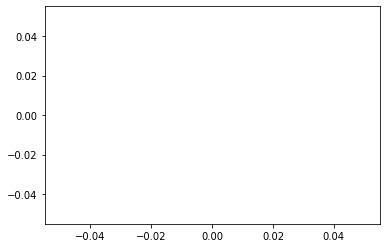

In [53]:
plt.plot(losses.gen_loss.values)

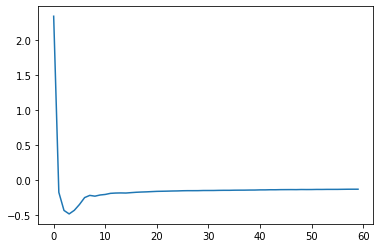

In [ ]:
plt.plot(losses.disc_loss.values)

In [ ]:
!zip -r /content/file.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/img_40.png (deflated 8%)
  adding: content/images/img_48.png (deflated 8%)
  adding: content/images/img_28.png (deflated 7%)
  adding: content/images/img_56.png (deflated 8%)
  adding: content/images/img_16.png (deflated 8%)
  adding: content/images/img_4.png (deflated 7%)
  adding: content/images/img_8.png (deflated 7%)
  adding: content/images/img_36.png (deflated 8%)
  adding: content/images/img_24.png (deflated 8%)
  adding: content/images/img_44.png (deflated 8%)
  adding: content/images/img_32.png (deflated 7%)
  adding: content/images/img_12.png (deflated 7%)
  adding: content/images/img_52.png (deflated 8%)
  adding: content/images/img_20.png (deflated 8%)
  adding: content/images/img_0.png (deflated 8%)
